In [2]:
import numpy as np
from sklearn.decomposition import PCA
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter
img1 = cv2.imread('C:\\personal\\mini project\\image1.png')
blur1 = cv2.GaussianBlur(img1,(5,5), 0)
bilater1= cv2.bilateralFilter(img1, 5, 50,50,)
img2 = cv2.imread('C:\\personal\\mini project\\image2.png')
blur2 = cv2.GaussianBlur(img2,(5,5), 0)
bilater2= cv2.bilateralFilter(img2, 5, 50,50,)

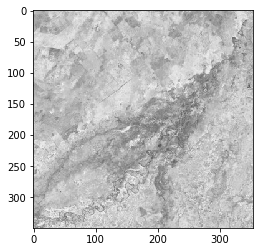

In [3]:
plt.imshow(img1)

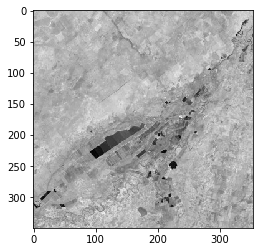

In [4]:
plt.imshow(img2)

In [5]:
def find_vector_set(diff_image, dsize):

    i = 0
    j = 0
    vector_set = np.zeros((int(dsize[0] * dsize[1] / 75),75))
    while i < vector_set.shape[0]:
        while j < dsize[0]:
            k = 0
            while k < dsize[1]:
                block   = diff_image[j:j+5, k:k+5]
                feature = block.ravel()
                vector_set[i, :] = feature
                k = k + 5
            j = j + 5
        i = i + 1

    mean_vec   = np.mean(vector_set, axis = 0)
    vector_set = vector_set - mean_vec   #mean normalization

    return vector_set, mean_vec

In [6]:
def find_FVS(EVS, diff_image, mean_vec, dsize):
 
    i = 2
    feature_vector_set = []
 
    while i < dsize[0] - 2:
        j = 2
        while j < dsize[1] - 2:
            block = diff_image[i-2:i+3, j-2:j+3]
            feature = block.flatten()
            feature_vector_set.append(feature)
            j = j+1
        i = i+1
 
    FVS = np.dot(feature_vector_set, EVS)
    FVS = FVS - mean_vec
    return FVS

In [7]:
def clustering(FVS, components, dsize): 
 
    kmeans = KMeans(components, verbose = 0) #function to form Kmeans clustering using function where K=3 
    kmeans.fit(FVS) #to fit to the shape of feature vector
    output = kmeans.predict(FVS) 
    count  = Counter(output) #gives output in the form of dictionary with the number of pixels in each cluster
    
    
 
    least_index = min(count, key = count.get) #finds the cluster with least pixels using argument key which sorts according to key of dictionary
    change_map  = np.reshape(output,(dsize[0] -4 , dsize[1]-4 )) #change map with changed size
    return least_index, change_map

dsize = (350, 350)


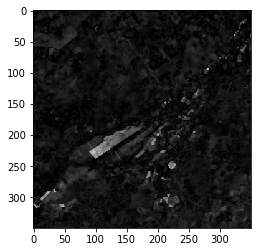

In [8]:
new_size = np.asarray(bilater1.shape) / 5 # to obtain pixels number as a multiple of 5
new_size = new_size.astype(int) * 5
new_size = list(new_size) 
new_size.remove(0)
dsize = tuple(new_size) #to convert to tuple to debug error obtained
print("dsize =", dsize)
img3 = cv2.resize(bilater1, (350,350)).astype(np.int16)#to make both the images of same size
#print("img3 size = ", img3.shape)
img4 = cv2.resize(bilater2, (350,350)).astype(np.int16)
diff_image = abs(img3 - img4) #to obtain difference image
#print ("\ndiff image size", diff_image.shape)
a=plt.imshow(diff_image) #to plot difference image

In [9]:
vector_set, mean_vec = find_vector_set(diff_image, dsize) #call function to find vector set
pca     = PCA() #inbuilt function to apply PCA
pca.fit(vector_set)
EVS = pca.components_ #to obtain principle components
print ("\n eigen vector space size", EVS.shape)


 eigen vector space size (75, 75)


In [10]:
FVS = find_FVS(EVS, diff_image, mean_vec, dsize) #calling function to obtain feature vector set

 

In [11]:
Sum_of_squared_distances = []
K = range(1,9)
for k in K:
    print(k)
    km = KMeans(n_clusters=k)
    km = km.fit(FVS)
    Sum_of_squared_distances.append(km.inertia_)
    print(km.inertia_)

1
2975764935.6656995
2
1835465947.9041836
3
1319741951.157584
4
1116444422.520196
5
1021904256.2091256
6
964838652.187788
7
915577298.8258493
8
876983428.8393062


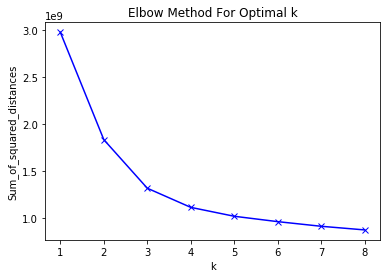

In [12]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [18]:
components = 3
least_index, change_map = clustering(FVS, components, dsize) # calling clustering function

In [19]:
change_map[change_map == least_index] = 255 #setting values  f of high and low to obtain binary change map
change_map[change_map != 255] = 0
 
change_map = change_map.astype(np.uint8)

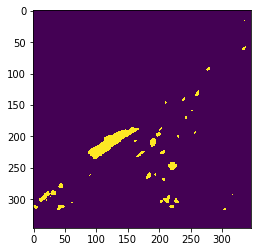

In [20]:
plt.imshow(change_map)

In [21]:
kernel     = np.asarray(((0,0,1,0,0), #structuring element to perform erosion on change map
                             (0,1,1,1,0),
                             (1,1,1,1,1),
                             (0,1,1,1,0),
                             (0,0,1,0,0)), dtype=np.uint8)
cleanChangeMap = cv2.erode(change_map,kernel)

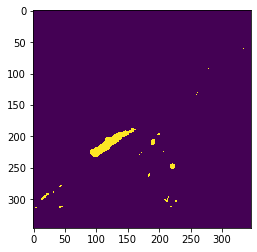

In [22]:
plt.imshow(cleanChangeMap)